In [1]:
import os
import pickle

import numpy as np
import pandas
import tqdm as tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

plt.rcParams['savefig.dpi'] = 300


def load_dataset(dir):
    stances = pandas.read_csv(f"{dir}_stances.csv")
    body = pandas.read_csv(f"{dir}_bodies.csv")
    stances = stances.merge(body, on="Body ID")
    stances["related_class"] = stances["Stance"].map({"unrelated": 0, "discuss": 1, "agree": 1, "disagree": 1})
    del body
    return stances

In [5]:
DRIVE = True
if DRIVE:
    # from google.colab import drive
    # drive.mount("/content/drive")
    # import sys
    # sys.path.insert(0,'/content/drive/My Drive/dissertation data')
    # relative_dir = "/content/drive/My Drive/dissertation data/"
    !pip install gdown
    !gdown https://drive.google.com/drive/folders/1tMszfJD-Mv9Qk816Ww-LcAusepo1PQOQ?usp=sharing --folder
    relative_dir = "./"
else:
    relative_dir = "./"

Retrieving folder list
Processing file 114-4MtWtiK80M-eXRPzDt8ZarpTiwgqU bert_tokenised.pickle
Processing file 1lQGsQdaVW9EPUDPhLeZ6fRKSI_oEyah4 competition_test_bodies.csv
Processing file 1e0SXxWhmg1uPXrGNfajSAAn9Go23vhFK competition_test_stances.csv
Processing file 1JBJXQafokgL2hmJTknuhafp4fDrcd-j4 LSTM_bert_trained.pt
Processing file 1lRnrxc1EgBQqBh5mdeG49U4iW6VB7LHi LSTM_TDIDF_final.pt
Processing file 1gP7uBiOgEteFwI5PB7JRFThe9jMIGz9S roberta_base_fine_tuned_finalv6_updateddropout.pt
Processing file 1mZTiy_aMBXd-x6dXxnrLtxi8WhaIu0qM roberta_base_fine_tuned_finalv6_updateddropout2.pt
Processing file 1-ANXCda81b3hNS3fauWjdPQ9PUOyhpHE tfidfVectoriser_trained.pickle
Processing file 1Cz34LayU94PHN7F8uWL3U9HntuXhMNul train_bodies.csv
Processing file 1e3RIhvzY6bfkxrkTsZkcFXt6SPfIRqjU train_stances.csv
Processing file 1-9YkYb8q3l7rYsvtjEa9dq2kZTv_W7wD xgb_bert.pickle
Processing file 172g4jFeQ8pTOvgZCZy8Ye90DRl2hLEtG xgb_tfidf.pickle
Retrieving folder list completed
Building directory struc

In [6]:
NOTEBOOK = True
run_tfidf = None
run_bert = None
run_3class = None
if not NOTEBOOK:
    import neptune.new as neptune
    run_tfidf = neptune.init(
        project="julian-wyatt/NLP",
        api_token="",
    )
    run_bert = neptune.init(
        project="julian-wyatt/NLP",
        api_token="",
    )
    run_3class = neptune.init(
        project="julian-wyatt/NLP",
        api_token="",
    )

In [7]:
stances_train = load_dataset(f"{relative_dir}train")
stances_eval = load_dataset(f"{relative_dir}competition_test")
stances_train.sample(10)
del stances_train["Body ID"]
del stances_eval["Body ID"]

# 1a Extract features via TF-IDF

In [8]:
def merge_headline_article(headline, body):
    return f"{headline}, {body}"
stances_train["input_sentence"] = list(
    map(
        merge_headline_article, stances_train["Headline"],
        stances_train["articleBody"]
        )
    )
stances_eval["input_sentence"] = list(
    map(
        merge_headline_article, stances_eval["Headline"],
        stances_eval["articleBody"]
        )
    )

In [9]:
TFIDF_DIMS = 2048
if not os.path.exists(f"{relative_dir}tfidfVectoriser_trained.pickle"):
    tfidf = TfidfVectorizer(
            decode_error='ignore', lowercase=True, min_df=5, strip_accents="ascii", max_features=TFIDF_DIMS,
            ngram_range=(1, 2)
            )
    # fit transform tfidf
    train_tfidf_X = tfidf.fit_transform((stances_train["input_sentence"]).values.astype('U'))
    eval_tfidf_X = tfidf.transform(stances_eval["input_sentence"].values.astype('U'))
    with open(f"{relative_dir}tfidfVectoriser_trained.pickle", "wb") as f:
        pickle.dump((tfidf, train_tfidf_X, eval_tfidf_X), f)
else:
    with open(f"{relative_dir}tfidfVectoriser_trained.pickle", "rb") as f:
        (tfidf, train_tfidf_X, eval_tfidf_X) = pickle.load(f)
del stances_train["input_sentence"]
del stances_eval["input_sentence"]


# 1a Extract features via a Transformer

In [10]:
!pip install transformers
from transformers import BertTokenizer, BertModel
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transformer_embedding = BertModel.from_pretrained("bert-base-uncased")
transformer_embedding = transformer_embedding.to(device)
tokeniser_bert = BertTokenizer.from_pretrained("bert-base-uncased")


     |████████████████████████████████| 4.2 MB 17.4 MB/s 
     |████████████████████████████████| 6.6 MB 57.8 MB/s 
     |████████████████████████████████| 596 kB 61.6 MB/s 
     |████████████████████████████████| 84 kB 3.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

In [11]:
def tokenise_embed_article(headline,body):
    tokens = tokeniser_bert(
        text=headline, text_pair=body, add_special_tokens=True, truncation="only_second",
        padding=True, return_tensors="pt"
        )
    tokens = tokens.to(device)
    with torch.no_grad():
        embedding = transformer_embedding(**tokens)
    return embedding[0][:, 0, :]

BATCH_SIZE = 50

In [12]:
# generate transformer article embedding
if not os.path.exists(f"{relative_dir}bert_tokenised.pickle"):
    headlines = list(stances_train["Headline"])
    bodies = list(stances_train["articleBody"])
    bert_tokenised_train = torch.empty((len(headlines), 768))
    for i in tqdm.tqdm(range(0, len(headlines), BATCH_SIZE)):
        bert_tokenised_train[i:i + BATCH_SIZE] = tokenise_embed_article(
                headlines[i:i + BATCH_SIZE], bodies[i:i + BATCH_SIZE]
                )

    headlines = list(stances_eval["Headline"])
    bodies = list(stances_eval["articleBody"])
    bert_tokenised_eval = torch.empty((len(headlines), 768))
    for i in tqdm.tqdm(range(0, len(headlines), BATCH_SIZE)):
        bert_tokenised_eval[i:i + BATCH_SIZE] = tokenise_embed_article(
                headlines[i:i + BATCH_SIZE], bodies[i:i + BATCH_SIZE]
                )
    del headlines, bodies
    with open(f"{relative_dir}bert_tokenised.pickle", "wb") as f:
        pickle.dump((bert_tokenised_train, bert_tokenised_eval), f)
else:
    with open(f"{relative_dir}bert_tokenised.pickle", "rb") as f:
            bert_tokenised_train, bert_tokenised_eval = pickle.load(f)

# 2a i) Train classic ML classifier [Unrelated|Related] - TF-IDF embeddings

In [13]:
from xgboost import XGBClassifier

X_train, X_val, y_train, y_val = train_test_split(
    train_tfidf_X, stances_train["related_class"].values, test_size=0.20, random_state=0
    )

# set the model parameters
params = {
    # Parameters that we are going to tune.
    "n_estimators":     75,
    'max_depth':        6,
    'min_child_weight': 1,
    'eta':              .2,
    'subsample':        1,
    'colsample_bytree': 1,
    # Other parameters
    # 'objective':'reg:linear',
    }
if device == torch.device("cuda"):
    params['gpu_id'] = 0
if not os.path.exists(f"{relative_dir}xgb_tfidf.pickle"):
    xgb_tfidf = XGBClassifier(**params)

    # Fit or train the xgboost model
    xgb_tfidf.fit(
        X_train, y_train, eval_set=[(X_val, y_val), (eval_tfidf_X, stances_eval["related_class"])], verbose=50
        )
    with open(f"{relative_dir}xgb_tfidf.pickle", "wb") as f:
        pickle.dump(xgb_tfidf,f)
else:
    with open(f"{relative_dir}xgb_tfidf.pickle", "rb") as f:
        xgb_tfidf = pickle.load(f)
y_val_pred = xgb_tfidf.predict(X_val)
y_eval_pred = xgb_tfidf.predict(eval_tfidf_X)

In [14]:
print("TF-IDF XGBOOST")
print("Validation Classification Report:")
print(classification_report(y_val, y_val_pred, labels=[0, 1], target_names=["Unrelated", "Related"], digits=4))
print("Test Classification Report:")
print(
    classification_report(
            stances_eval["related_class"], y_eval_pred, labels=[0, 1], target_names=["Unrelated", "Related"], digits=4
            )
    )

TF-IDF XGBOOST
Validation Classification Report:
              precision    recall  f1-score   support

   Unrelated     0.8292    0.9955    0.9047      7269
     Related     0.9740    0.4530    0.6184      2726

    accuracy                         0.8475      9995
   macro avg     0.9016    0.7243    0.7616      9995
weighted avg     0.8686    0.8475    0.8266      9995

Test Classification Report:
              precision    recall  f1-score   support

   Unrelated     0.7206    0.9450    0.8177     18349
     Related     0.2526    0.0483    0.0811      7064

    accuracy                         0.6957     25413
   macro avg     0.4866    0.4966    0.4494     25413
weighted avg     0.5905    0.6957    0.6129     25413



In [15]:
del xgb_tfidf
del y_eval_pred
del y_val_pred
del X_train
del X_val
del y_train
del y_val
del train_tfidf_X

# 2a i) Train classic ML classifier [Unrelated|Related] - Transformer embeddings

In [16]:
X_train, X_val, y_train, y_val = train_test_split(
    bert_tokenised_train, stances_train["related_class"].values, test_size=0.20,
    random_state=0
    )

# set the model parameters
params = {
    # Parameters that we are going to tune.
    "n_estimators":     150,
    'max_depth':        6,
    'min_child_weight': 1,
    'eta':              .15,
    'subsample':        1,
    'colsample_bytree': 1,
    # Other parameters
    # 'objective':'reg:linear',
    }
if device == torch.device("cuda"):
    params['gpu_id'] = 0
if not os.path.exists(f"{relative_dir}xgb_bert.pickle"):
    xgb_bert = XGBClassifier(**params)

    # Fit or train the xgboost model
    xgb_bert.fit(
        X_train, y_train, eval_set=[(X_val, y_val), (bert_tokenised_eval, stances_eval["related_class"])], verbose=50
        )

    with open(f"{relative_dir}xgb_bert.pickle", "wb") as f:
        pickle.dump(xgb_bert, f)
else:
    with open(f"{relative_dir}xgb_bert.pickle", "rb") as f:
        xgb_bert = pickle.load(f)
y_val_pred = xgb_bert.predict(X_val)
y_eval_pred = xgb_bert.predict(bert_tokenised_eval)

In [17]:
print("BERT XGBOOST")
print("Validation Classification Report:")
print(classification_report(y_val, y_val_pred, labels=[0, 1], target_names=["Unrelated", "Related"], digits=4))
print("Test Classification Report:")
print(
    classification_report(
            stances_eval["related_class"], y_eval_pred, labels=[0, 1], target_names=["Unrelated", "Related"], digits=4
            )
    )

BERT XGBOOST
Validation Classification Report:
              precision    recall  f1-score   support

   Unrelated     0.9916    0.9950    0.9933      7269
     Related     0.9867    0.9776    0.9821      2726

    accuracy                         0.9903      9995
   macro avg     0.9892    0.9863    0.9877      9995
weighted avg     0.9903    0.9903    0.9903      9995

Test Classification Report:
              precision    recall  f1-score   support

   Unrelated     0.9859    0.9865    0.9862     18349
     Related     0.9648    0.9633    0.9641      7064

    accuracy                         0.9800     25413
   macro avg     0.9754    0.9749    0.9751     25413
weighted avg     0.9800    0.9800    0.9800     25413



In [18]:
del xgb_bert
del y_eval_pred
del y_val_pred
del X_train
del X_val
del y_train
del y_val
del bert_tokenised_train
del bert_tokenised_eval

# Q2a ii) - Deep model [Unrelated|related] - TFIDF embeddings

In [19]:
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torch.optim as optim

In [20]:
class FakeNewsDataset(Dataset):
    """Fake News dataset."""

    def __init__(self, headlines, body, label, use_bert_embeddings=True, label3class=None, tokeniser=None):
        self.headlines = list(headlines)
        self.body = list(body)
        self.use_bert_embeddings = use_bert_embeddings
        self.labels = list(label)
        if label3class is not None:
            self.label3class = list(label3class)
        else:
            self.label3class = label3class
        self.tokeniser = tokeniser

    def __len__(self):
        return len(self.headlines)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        if self.use_bert_embeddings:
            if self.tokeniser is not None:
                tokenised = self.tokeniser(
                    text=self.headlines[idx], text_pair=self.body[idx], add_special_tokens=True,
                    padding='max_length', truncation="only_second", max_length=512, return_tensors="pt"
                    )
            else:
                tokenised = tokeniser_bert(
                        text=self.headlines[idx], text_pair=self.body[idx], add_special_tokens=True,
                        padding='max_length', truncation="only_second", max_length=512, return_tensors="pt"
                        )

        else:
            tokenised = tfidf.transform([f"{self.headlines[idx]}, {self.body[idx]}"]).toarray()
            tokenised = torch.from_numpy(tokenised.astype(np.float32))

        sample = {"X": tokenised, "Y": torch.from_numpy(np.array(self.labels[idx])).long()}
        if self.label3class:
            sample["Y3"] = torch.from_numpy(np.array(self.label3class[idx])).long()
            sample["X3"] = tokeniser_roberta(
                    text=self.headlines[idx], text_pair=self.body[idx], add_special_tokens=True,
                    padding='max_length', truncation="only_second", max_length=512, return_tensors="pt"
                    )

        return sample

split_idx = int(len(stances_train["Headline"]) * 0.8)

headline_train, body_train = stances_train["Headline"][:split_idx], stances_train["articleBody"][:split_idx]
y_train = stances_train["related_class"][:split_idx]

headline_val, body_val = stances_train["Headline"][split_idx:], stances_train["articleBody"][split_idx:]
y_val = stances_train["related_class"][split_idx:]

# weighted random sampler:
# https://discuss.pytorch.org/t/how-to-handle-imbalanced-classes/11264/2

class_sample_count = np.array(
        [len(np.where(y_train == t)[0]) for t in np.unique(y_train)]
        )
weight = 1. / class_sample_count
samples_weight = np.array([weight[t] for t in y_train])

samples_weight = torch.from_numpy(samples_weight)
samples_weight = samples_weight.double()
sampler = WeightedRandomSampler(samples_weight, len(samples_weight))

In [21]:
# Following few cells are from practical 4,
# Generally they've been heavily edited from their source

class TEXT_LSTM(nn.Module):

    def __init__(self, dimension=256, n_class=1, bidirectional=True, use_bert_embedding=True, n_layers=2, dropout=0.5):
        super(TEXT_LSTM, self).__init__()

        self.use_bert_embedding = use_bert_embedding
        if use_bert_embedding:
            self.embedding = transformer_embedding
            embedding_dim = transformer_embedding.config.to_dict()['hidden_size']
        else:
            embedding_dim = TFIDF_DIMS
            self.embedding = None
        self.act = nn.Sigmoid()

        self.dimension = dimension
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=dimension,
            num_layers=n_layers,
            batch_first=True,
            bidirectional=bidirectional
            )
        self.dropout = nn.Dropout(p=dropout)
        self.fc = nn.Linear(2 * dimension if bidirectional else dimension, n_class)  # add a linear layer


    def forward(self, text):
        if self.use_bert_embedding:
            # 'input_ids', 'token_type_ids', 'attention_mask'
            with torch.no_grad():
                text_emb = self.embedding(**text)[0]
        else:
            text_emb = text

        _, (hidden, cn) = self.lstm(text_emb)
        # outputs: output, hidden state n, cell state n
        if self.lstm.bidirectional:
            hidden = self.dropout(torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1))
        else:
            hidden = self.dropout(hidden[-1, :, :])

        output = self.fc(hidden)
        text_out = self.act(output)  # Sigmoid is used to get the probability of the sequence being FAKE (1)
        return text_out

In [22]:
def accuracy(preds, y):
    """
    Returns accuracy per batch
    """
    # round predictions to the closest integer
    if preds.shape[1] == 1:
        argmax = torch.round(preds).squeeze()
        y = y.squeeze()
    else:
        preds = nn.Softmax(dim=1)(preds)
        argmax = torch.argmax(preds, dim=1)

    correct = (argmax == y.squeeze()).float()  # convert into float for division
    acc = correct.sum() / len(correct)
    return acc

In [23]:
def train(model, iterator, optimiser, criterion, run=None, annealLR=False, epoch=0):
    epoch_loss = 0
    epoch_acc = 0

    model.train()
    for i, batch in enumerate(iterator):
        optimiser.zero_grad()

        X, y = batch["X"], batch["Y"]
        if model.embedding:
            for key in X.keys():
                X[key] = X[key].to(device).squeeze(1)
        else:
            X = X.to(device)
        y = y.to(device)

        predictions = model(X)

        loss = criterion(predictions, y)

        acc = accuracy(predictions, y)

        loss.backward()

        optimiser.step()

        if annealLR:
            update_annealLR(len(iterator) * (epoch) + i, epoch, optimiser)

        epoch_loss += loss.item()
        epoch_acc += acc.item()
        if i % 25 == 0 and not NOTEBOOK:
            run["train/running-loss"].log(loss.item())
            run["train/running-acc"].log(acc.item())
            run["parameters/lr"].log(optimiser.param_groups[0]['lr'])

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [24]:
def evaluate(model, iterator, criterion, test_set=False, model3class=None, run=None, record_predictions=False):
    """
    :param model: primary evaluation model - for end 2 end, must be a related | unrelated model
    :param iterator: validation iterator
    :param criterion: cross entropy function
    :param test_set: if test set or validation set
    :param model3class: end 2 end 3 class model
    :param run: Nuptune / tensorboard logger
    :param record_predictions: ["probs"|"preds"|False] - return probabilities | predictions (rounded/ argmaxed) |
    don't return predictions
    :return:
    """
    epoch_loss = 0
    epoch_acc = 0

    model.eval()
    y_preds = []
    y_true = []

    with torch.no_grad():

        for i, batch in enumerate(iterator):

            X, y = batch["X"], batch["Y"]
            if model.embedding:
                for key in X.keys():
                    X[key] = X[key].to(device).squeeze(1)
            else:
                X = X.to(device)
            y = y.to(device)
            related_predictions = model(X)

            if model3class:
                x3 = batch["X3"]
                y3 = batch["Y3"].to(device)
                argmax = related_predictions.round().squeeze()

                y_preds.extend((related_predictions[(argmax == 0).nonzero()].squeeze().round().cpu().numpy())
                               .flatten())
                y_true.extend((y3[(argmax == 0).nonzero()].squeeze().cpu().numpy()).flatten()+1)
                if len(y[(argmax == 1).nonzero()]) > 0:

                    # Add accuracy where prediction is 1
                    if model.embedding:
                        for key in x3.keys():
                            x3[key] = x3[key][(argmax == 1).nonzero()].squeeze().to(device)
                            if len(x3[key].shape)==1:
                                x3[key] = x3[key].unsqueeze(0)

                    y = y3[(argmax == 1).nonzero()].squeeze()

                    related_predictions = model3class(x3)
                    y_preds.extend((related_predictions.argmax(dim=1).cpu().numpy()+1).flatten())
                    y_true.extend((y.squeeze().cpu().numpy()+1).flatten())

            else:
                if record_predictions == "probs":
                    y_preds.extend(related_predictions.cpu().numpy().flatten())
                elif record_predictions == "preds" and related_predictions.shape[1] == 1:
                    y_preds.extend(related_predictions.cpu().numpy().flatten())
                elif record_predictions == "preds":
                    y_preds.extend(related_predictions.argmax(dim=1).cpu().numpy().flatten())
                y_true.extend(y.cpu().numpy().flatten())
                loss = criterion(related_predictions, y)
                epoch_loss += loss.item()
            acc = accuracy(related_predictions, y)
            epoch_acc += acc.item()
            if i % 50 == 0 and not NOTEBOOK:
                if test_set:
                    run["test/running-loss"].log(loss.item())
                    run["test/running-acc"].log(acc.item())
                else:
                    run["val/running-loss"].log(loss.item())
                    run["val/running-acc"].log(acc.item())

    y_preds = np.array(y_preds)
    y_true = np.array(y_true)

    if record_predictions:
        return epoch_loss / len(iterator), epoch_acc / len(iterator), y_preds, y_true
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [25]:
import time

def epoch_time(start_time, current_epoch, end_epoch):
    elapsed_time = time.time() - start_time
    elapsed_mins = int(elapsed_time / 60)
    time_per_epoch = elapsed_time / (current_epoch + 1)
    if time_per_epoch * (end_epoch - current_epoch) > 3600:
        hours = time_per_epoch * (end_epoch - current_epoch) / 3600
        minutes = (hours % 1) * 60
        time_remaining = f"{hours:.0f}:{minutes:.1f}"
    else:
        time_remaining = f"{time_per_epoch * (end_epoch - current_epoch) // 60} mins"
    return elapsed_mins, time_remaining

In [26]:
def training_loop(
        model, EPOCHS, optimiser, dataloader_training, dataloader_validation, criterion, output_filename,
        run=None, anneal_lr=False
        ):
    # Train the model
    best_valid_acc = 0

    start_time = time.time()
    for epoch in range(EPOCHS + 1):

        train_loss, train_acc = train(
            model, dataloader_training, optimiser, criterion, run=run, annealLR=anneal_lr,
            epoch=epoch
            )

        valid_loss, valid_acc = evaluate(model, dataloader_validation, criterion, run=run)

        elapsed_mins, time_remaining = epoch_time(start_time, epoch, EPOCHS)

        if valid_acc > best_valid_acc:
            best_valid_acc = valid_acc
            torch.save(model.state_dict(), output_filename)

        if not NOTEBOOK:
            run["train/loss"].log(train_loss)
            run["train/acc"].log(train_acc)

            run["valid/loss"].log(valid_loss)
            run["valid/acc"].log(valid_acc)

        print(f"{elapsed_mins} mins elapsed, {time_remaining} remaining, epoch = {epoch}")
        print(f"Train Loss {train_loss:.3f} | Train Acc {train_acc:.3f} ")
        print(f"Valid Loss {valid_loss:.3f} | Valid Acc {valid_acc:.3f} | Best Valid Acc {best_valid_acc}\n")


In [27]:
def update_annealLR(step, epoch, optimiser):
    if epoch < 1:
        # v2
        lr = 2e-5 * (1.0012) ** step
        # v2.5
        # lr = 2e-5 * (1.0005) ** step
    elif epoch < 10:
        # lr = 1.2e-4 * (0.99955) ** (step - 1120 * 2)
        # v2:
        lr = 7.5e-5 * (0.9997) ** (step - 1120 * 1)
        # v7:
        # lr = 2.9e-4 * (0.99965) ** (step - 1120 * 2)
        # v2.5:
        # lr = 1e-4 * (0.9997) ** (step - 1120 * 3)
    else:
        # v2:
        lr = 5e-6
        # lr = 9e-6
    optimiser.param_groups[0]['lr'] = lr

In [28]:
criterion_BCE = nn.BCELoss().to(device)
criterion_CE = nn.CrossEntropyLoss().to(device)
def criterion(prediction, y):
    if prediction.shape[1] == 1:
        prediction = prediction.squeeze()
        return criterion_BCE(prediction, y.float())
    else:
        return criterion_CE(prediction, y.long())

In [29]:
tfidf_BATCH_SIZE = 128
training_dataset = FakeNewsDataset(headline_train, body_train, y_train, False)
validation_dataset = FakeNewsDataset(headline_val, body_val, y_val, False)
testing_dataset = FakeNewsDataset(
        stances_eval["Headline"], stances_eval["articleBody"],
        stances_eval["related_class"], False
        )

dataloader_training = DataLoader(
    training_dataset, batch_size=tfidf_BATCH_SIZE,
    num_workers=0, sampler=sampler
    )
dataloader_validation = DataLoader(
    validation_dataset, batch_size=tfidf_BATCH_SIZE,
    num_workers=0, )
dataloader_test = DataLoader(
    testing_dataset, batch_size=tfidf_BATCH_SIZE,
    num_workers=0, )

In [30]:
LSTM_tfidf = TEXT_LSTM(use_bert_embedding=False)
optim_tfidf = optim.AdamW(LSTM_tfidf.parameters())
LSTM_tfidf.to(device)

TEXT_LSTM(
  (act): Sigmoid()
  (lstm): LSTM(2048, 256, num_layers=2, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=512, out_features=1, bias=True)
)

In [31]:
load_saved_model = True
filename = f"{relative_dir}LSTM_TDIDF_final.pt"

if not NOTEBOOK:
    run_tfidf["parameters/type"] = "TF-IDF"
    run_tfidf["parameters/RNN"] = True
if load_saved_model:
    LSTM_tfidf.load_state_dict(torch.load(filename, map_location=device))
else:
    training_loop(
            LSTM_tfidf, EPOCHS=50, optimiser=optim_tfidf, dataloader_training=dataloader_training,
            dataloader_validation=dataloader_validation, criterion=criterion,
            output_filename=filename, run=run_tfidf
            )

In [32]:
# Test
test_loss, test_accuracy, y_preds_tfidf, y_true_tfidf = evaluate(LSTM_tfidf, dataloader_test, criterion,
                                                                 run=run_tfidf, record_predictions="probs")
print(f"Test set loss {test_loss:.3f} | Acc {test_accuracy:.3f}")

Test set loss 12.265 | Acc 0.567


# Q2a ii) - Deep model [Unrelated|related] - pretrained BERT embeddings

In [33]:
BERT_BATCH_SIZE = 20
training_dataset = FakeNewsDataset(headline_train, body_train, y_train, True)
validation_dataset = FakeNewsDataset(headline_val, body_val, y_val, True)
testing_dataset = FakeNewsDataset(
        stances_eval["Headline"], stances_eval["articleBody"],
        stances_eval["related_class"], True
        )

dataloader_training = DataLoader(
    training_dataset, batch_size=BERT_BATCH_SIZE,
    num_workers=0, sampler=sampler
    )
dataloader_validation = DataLoader(
    validation_dataset, batch_size=BERT_BATCH_SIZE,
    num_workers=0, )
dataloader_test = DataLoader(
    testing_dataset, batch_size=BERT_BATCH_SIZE,
    num_workers=0, )

In [34]:
LSTM_bert = TEXT_LSTM(use_bert_embedding=True)
optim_bert = optim.AdamW(LSTM_bert.parameters())
LSTM_bert.to(device)

TEXT_LSTM(
  (embedding): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tru

In [35]:
load_saved_model = True
filename = f"{relative_dir}LSTM_bert_trained.pt"
if not NOTEBOOK:
    run_bert["parameters/type"] = "BERT"
if load_saved_model:
    LSTM_bert.load_state_dict(torch.load(filename, map_location=device))
else:
    training_loop(
        LSTM_bert, EPOCHS=15, optimiser=optim_bert, dataloader_training=dataloader_training,
        dataloader_validation=dataloader_validation, criterion=criterion, output_filename=filename,
            run=run_bert )


In [36]:
# Test
test_loss, test_accuracy, y_preds_bert, y_true_bert = evaluate(LSTM_bert, dataloader_test, criterion, test_set=True,
                                                     run=run_bert, record_predictions="probs")
print(f"Test set loss {test_loss:.3f} | Acc {test_accuracy:.3f}")

Test set loss 0.056 | Acc 0.985


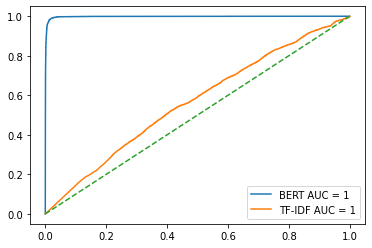

In [37]:
# ROC Curve

fpr,tpr,_ = roc_curve(y_true_bert, y_preds_bert)
plt.plot(fpr,tpr, label=f'BERT AUC = {roc_auc_score(y_true_bert, y_preds_bert):.3f}')
fpr,tpr,_ = roc_curve(y_true_tfidf, y_preds_tfidf)
plt.plot(fpr,tpr, label=f'TF-IDF AUC = {roc_auc_score(y_true_tfidf, y_preds_tfidf):.3f}')
plt.plot(np.linspace(0,1,20),np.linspace(0,1,20),"--")
plt.legend(loc='lower right')
plt.savefig(f"{relative_dir}roc.png")
plt.show()

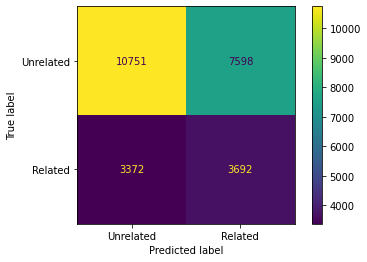

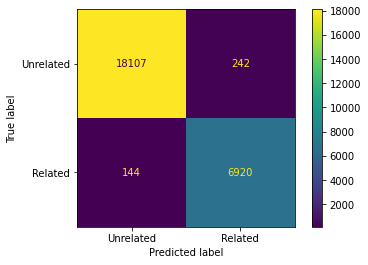

In [38]:
y_preds_bert = np.round(y_preds_bert)
y_preds_tfidf = np.round(y_preds_tfidf)
cm = confusion_matrix(y_true_tfidf, y_preds_tfidf, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=["Unrelated", "Related"])
disp.plot()
plt.savefig(f"{relative_dir}TF-IDF-CM.png")
plt.show()

cm = confusion_matrix(y_true_bert, y_preds_bert, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=["Unrelated", "Related"])
disp.plot()
plt.savefig(f"{relative_dir}BERT-CM.png")
plt.show()

In [39]:
print("TF-IDF Classification Report:")
print(classification_report(y_true_tfidf, y_preds_tfidf, labels=[0, 1], target_names=["Unrelated", "Related"], digits=4))
print("BERT Classification Report:")
print(classification_report(y_true_bert, y_preds_bert, labels=[0, 1], target_names=["Unrelated", "Related"], digits=4))

TF-IDF Classification Report:
              precision    recall  f1-score   support

   Unrelated     0.7612    0.5859    0.6622     18349
     Related     0.3270    0.5227    0.4023      7064

    accuracy                         0.5683     25413
   macro avg     0.5441    0.5543    0.5322     25413
weighted avg     0.6405    0.5683    0.5899     25413

BERT Classification Report:
              precision    recall  f1-score   support

   Unrelated     0.9921    0.9868    0.9895     18349
     Related     0.9662    0.9796    0.9729      7064

    accuracy                         0.9848     25413
   macro avg     0.9792    0.9832    0.9812     25413
weighted avg     0.9849    0.9848    0.9848     25413



# Q2b - Classify [Agree|Disagree|Discuss]

In [40]:
def related_only(df):
    stances_related_only = df[df["Stance"]!="unrelated"].copy()
    stances_related_only["related_class"] = stances_related_only["Stance"].map({"disagree":0,"discuss":1,"agree":2})
    return stances_related_only
stances_train_related = related_only(stances_train)
stances_eval_related = related_only(stances_eval)

In [41]:
headline_train, body_train = stances_train_related["Headline"], stances_train_related["articleBody"]
y_train = stances_train_related["related_class"]

# weighted random sampler:
# https://discuss.pytorch.org/t/how-to-handle-imbalanced-classes/11264/2

class_sample_count = np.array(
        [len(np.where(y_train == t)[0]) for t in np.unique(y_train)]
        )
weight = 1. / class_sample_count
samples_weight = np.array([weight[t] for t in y_train])

samples_weight = torch.from_numpy(samples_weight)
samples_weight = samples_weight.double()
sampler = WeightedRandomSampler(samples_weight, len(samples_weight))

In [42]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AutoConfig

configuration = AutoConfig.from_pretrained('roberta-base',num_labels=3)
configuration.classifier_dropout = 0.4
print(configuration)

tokeniser_roberta = AutoTokenizer.from_pretrained("roberta-base")
roberta = AutoModelForSequenceClassification.from_pretrained("roberta-base",config=configuration)

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": 0.4,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.19.2",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}



Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/478M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

In [43]:
BATCH_SIZE = 12
if not NOTEBOOK:
    run_3class["parameters/type"] = "3-class"
training_dataset = FakeNewsDataset(headline_train, body_train, y_train, True, tokeniser=tokeniser_roberta)
testing_dataset = FakeNewsDataset(
        stances_eval_related["Headline"], stances_eval_related["articleBody"],
        stances_eval_related["related_class"], True, tokeniser=tokeniser_roberta
        )

dataloader_training = DataLoader(
    training_dataset, batch_size=BATCH_SIZE,
    num_workers=0, sampler=sampler
    )
dataloader_test = DataLoader(
    testing_dataset, batch_size=BATCH_SIZE,
    num_workers=0, )

In [44]:
class Seq2Seq_Model(nn.Module):

    def __init__(self,seq2seqmodel):
        super(Seq2Seq_Model, self).__init__()

        self.model = seq2seqmodel
        self.act = nn.Softmax(dim=1)
        self.embedding = True

    def forward(self,text):

        output   = self.model(**text)[0]
        return self.act(output)

In [45]:
classifier = Seq2Seq_Model(roberta)
optim_classifier = optim.AdamW(classifier.parameters(), lr=2e-5, weight_decay=0.1)
classifier.to(device)
for param in classifier.model.roberta.parameters():
    param.requires_grad = False
classifier

Seq2Seq_Model(
  (model): RobertaForSequenceClassification(
    (roberta): RobertaModel(
      (embeddings): RobertaEmbeddings(
        (word_embeddings): Embedding(50265, 768, padding_idx=1)
        (position_embeddings): Embedding(514, 768, padding_idx=1)
        (token_type_embeddings): Embedding(1, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): RobertaEncoder(
        (layer): ModuleList(
          (0): RobertaLayer(
            (attention): RobertaAttention(
              (self): RobertaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): RobertaSelfOutput(
                (dense): Linear(i

In [46]:
load_saved_model = True
# filename = f'roberta_base_fine_tuned_finalv2-5.pt'
filename = f"{relative_dir}roberta_base_fine_tuned_finalv6_updateddropout.pt"
if load_saved_model:
    classifier.load_state_dict(torch.load(filename, map_location=device))
else:
    training_loop(
            classifier, EPOCHS=5, optimiser=optim_classifier, dataloader_training=dataloader_training,
            dataloader_validation=dataloader_test, criterion=criterion,
            output_filename=filename, run=run_3class, anneal_lr=False
            )

In [47]:
# Test
print("Fine tune 1")
test_loss, test_accuracy, y_preds_f1, y_true_f1= evaluate(classifier, dataloader_test, criterion, test_set=True,
                                                               run=run_3class, record_predictions="preds")
print(f"Test set loss {test_loss:.3f} | Acc {test_accuracy:.3f}")
print("3 Class fine tune 1 Classification Report:")
print(
    classification_report(y_true_f1, y_preds_f1, labels=[0, 1, 2],
                          target_names=["Disagree", "Discuss", "Agree"], digits=4)
    )

Fine tune 1
Test set loss 1.076 | Acc 0.522
3 Class fine tune 1 Classification Report:
              precision    recall  f1-score   support

    Disagree     0.2215    0.3659    0.2760       697
     Discuss     0.8246    0.4823    0.6086      4464
       Agree     0.3886    0.6742    0.4930      1903

    accuracy                         0.5225      7064
   macro avg     0.4782    0.5075    0.4592      7064
weighted avg     0.6476    0.5225    0.5446      7064



In [48]:
for param in classifier.model.roberta.parameters():
    param.requires_grad = True
for param in classifier.model.roberta.embeddings.parameters():
    param.requires_grad = False

In [49]:
load_saved_model = True
filename = f'{filename[:-3]:}2.pt'
if load_saved_model:
    classifier.load_state_dict(torch.load(filename,map_location=device))
else:
    training_loop(
            classifier, EPOCHS=12, optimiser=optim_classifier, dataloader_training=dataloader_training,
            dataloader_validation=dataloader_test, criterion=criterion,
            output_filename=filename, run=run_3class, anneal_lr=True
            )

In [50]:
# Test
print("Fine tune 2")
test_loss, test_accuracy, y_preds_3class, y_true_3class = evaluate(classifier, dataloader_test, criterion,
                                                                   test_set=True, run=run_3class,
                                                                   record_predictions="preds")
print(f"Test set loss {test_loss:.3f} | Acc {test_accuracy:.3f}")

Fine tune 2
Test set loss 0.742 | Acc 0.803


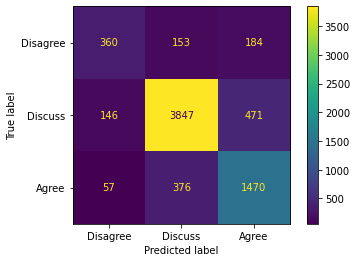

3 Class fine tune 2 Classification Report:
              precision    recall  f1-score   support

    Disagree     0.6394    0.5165    0.5714       697
     Discuss     0.8791    0.8618    0.8704      4464
       Agree     0.6918    0.7725    0.7299      1903

    accuracy                         0.8037      7064
   macro avg     0.7368    0.7169    0.7239      7064
weighted avg     0.8050    0.8037    0.8030      7064



In [51]:
# y_preds_3class = np.argmax(y_preds_3class,dim=1)

cm = confusion_matrix(y_true_3class, y_preds_3class, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Disagree", "Discuss", "Agree"]
    )
disp.plot()
plt.savefig(f"{relative_dir}3Class-CM.png")
plt.show()
print("3 Class fine tune 2 Classification Report:")
print(
    classification_report(y_true_3class, y_preds_3class, labels=[0, 1, 2],
                          target_names=["Disagree", "Discuss", "Agree"], digits=4)
    )

# Q2c - End to End Predictions

In [53]:
stances_eval["related_4class"] = stances_eval["Stance"].map({"unrelated":-1,"disagree":0,"discuss":1,"agree":2})

In [54]:
BATCH_SIZE = 8
testing_dataset = FakeNewsDataset(stances_eval["Headline"], stances_eval["articleBody"],
                                  stances_eval["related_class"], True,
                                  label3class=stances_eval["related_4class"])

dataloader_test = DataLoader(testing_dataset, batch_size=BATCH_SIZE,
                         num_workers=0,)

In [55]:
with torch.no_grad():
    test_loss, test_accuracy, y_preds_overall, y_true_overall = evaluate(LSTM_bert, dataloader_test, criterion,
                                                                   test_set=True, model3class=classifier,
                                                                         run=run_3class, record_predictions="preds")

print("Overall Classification Report")
print(
    classification_report(y_true_overall, y_preds_overall, labels=[0, 1, 2, 3],
                          target_names=["Unrelated", "Disagree", "Discuss", "Agree"], digits=4)
    )

Overall Classification Report
              precision    recall  f1-score   support

   Unrelated     0.9921    0.9868    0.9895     18349
    Disagree     0.6197    0.4351    0.5113       809
     Discuss     0.8469    0.8614    0.8541      4379
       Agree     0.6776    0.7729    0.7221      1876

    accuracy                         0.9318     25413
   macro avg     0.7841    0.7641    0.7692     25413
weighted avg     0.9320    0.9318    0.9312     25413



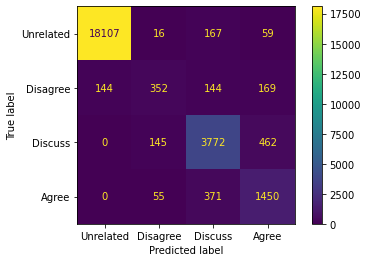

In [56]:
cm = confusion_matrix(y_true_overall, y_preds_overall, labels=[0, 1, 2, 3])
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Unrelated", "Disagree", "Discuss", "Agree"]
    )
disp.plot()
plt.savefig(f"{relative_dir}Overall-CM.png")
plt.show()